LOADED RESULTS
Parameters:
  K: 128
  L: 128
  D: 4
  N: 4
  B: 1
  epsilon: 0.001
  seed: 1
  exact_copy: True
  shuffle_context: True
  offset: 0.0
  min_max_choice: None
  unique_labels: False
  n_nodes: 5
  transform_func: exp
  learn_base_rates_W: True
  learn_base_rates_Y: False
  symmetrize_Y: True
  sparsity_rho_edge_K: 0.0
  sparsity_rho_all_K: 0.0
  sparsity_rho_edge_L: 0.04
  sparsity_rho_all_L: 1.0
  sparsity_rho_edge_base_W: 1.0
  sparsity_rho_edge_base_Y: 0.0
  base_mask_value: -inf
  epochs: 1000
  lr: 0.0025
  batch_size: 64
  train_samples: 25000
  val_samples: 2000
  method: newton
  temperature: 1.0

Execution time: 4064.23 seconds

Test Results:
Available keys: ['in_dist', 'novel_classes']
  in_dist: 50.1000
  novel_classes: 50.3000


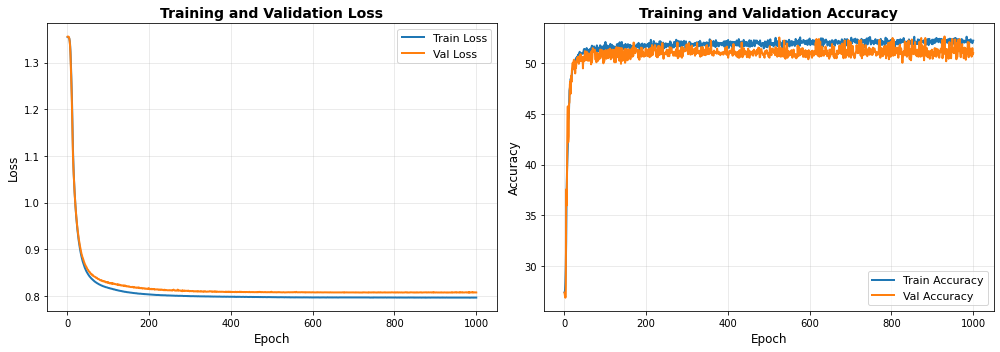


FINAL PERFORMANCE
Final Train Loss: 0.7965
Final Val Loss: 0.8075
Best Val Loss: 0.8071 (Epoch 930)
Final Train Accuracy: 52.2440
Final Val Accuracy: 51.0000
Best Val Accuracy: 52.6500 (Epoch 930)

ICL vs IWL ANALYSIS


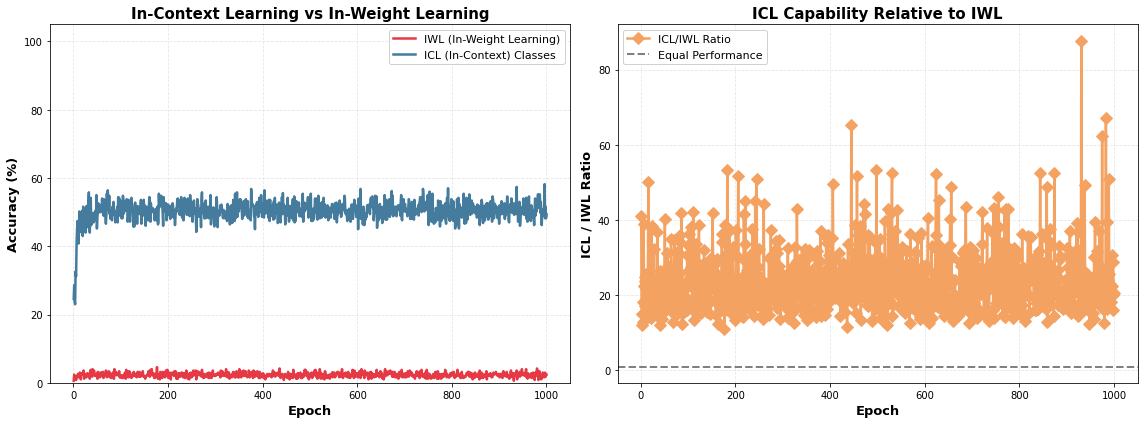


Final Accuracies:
  IWL (In-Weight):        2.40%
  ICL (In-Context) Classes:      49.40%

Best Accuracies:
  Best IWL:               4.60% (Epoch 177)
  Best ICL:         58.20% (Epoch 996)

Learning Mode Analysis:
  ✓ ICL-DOMINANT: Model prefers in-context learning


In [2]:
# Import necessary components
import torch
import numpy as np

# Import from refactored modular structure
from data_generation import GaussianMixtureModel, generate_icl_gmm_data
from datasets import ICLGMMDataset, collate_fn
from models import MatrixTreeMarkovICL, NonlinearMarkovICL
from training import train_model
from evaluation import test_icl

from models.nonlinear_markov_icl import *
from torch.utils.data import DataLoader
import os
import time

path = "/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/n_nodes/5/"
path = "/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/lr/0.001/"
path = "/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/D_K/2_4/"
path = "/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/N_n_nodes_verybig/6_6/"
path = "/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/rho_all_seed_n_nodes5_nlm0p2_15/0.6_3/"
path = "/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/rho_all_seed_n_nodes5_nlm_L_6/0.04_1/"
#path = "/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/rho_edge_seed_n_nodes4/0.5_2/"


import pickle
import matplotlib.pyplot as plt
import numpy as np

# Load the results
results_path = path + "results.pkl"
with open(results_path, "rb") as file:
    data = pickle.load(file)

# Extract components
results = data['results']
history = data['history']
params = data['params']
execution_time = data['execution_time']

# print("Needed dof: " + str(2 * params['D'] * params['N'] * (params['N']+1)))
# print("Available dof: " + str(params['sparsity_rho_all'] * params['sparsity_rho_edge'] * (params['N']+1) * params['D'] * params['n_nodes'] * (params['n_nodes']-1)))

# Print parameters
print("="*70)
print("LOADED RESULTS")
print("="*70)
print(f"Parameters:")
for key, value in params.items():
    print(f"  {key}: {value}")
print(f"\nExecution time: {execution_time:.2f} seconds")
print("="*70)


# Print test results (check what keys exist)
print("\nTest Results:")
print("Available keys:", list(results.keys()))
for key, value in results.items():
    if isinstance(value, (int, float)):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Loss curves
ax1 = axes[0]
epochs_plot = range(1, len(history['train_loss']) + 1)
ax1.plot(epochs_plot, history['train_loss'], label='Train Loss', linewidth=2)
ax1.plot(epochs_plot, history['val_loss'], label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 2: Accuracy curves (if available)
ax2 = axes[1]
if 'train_acc' in history and 'val_acc' in history:
    ax2.plot(epochs_plot, history['train_acc'], label='Train Accuracy', linewidth=2)
    ax2.plot(epochs_plot, history['val_acc'], label='Val Accuracy', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
else:
    # If no accuracy, plot loss on log scale
    ax2.semilogy(epochs_plot, history['train_loss'], label='Train Loss', linewidth=2)
    ax2.semilogy(epochs_plot, history['val_loss'], label='Val Loss', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss (log scale)', fontsize=12)
    ax2.set_title('Training and Validation Loss (Log Scale)', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

# Print final performance
print("\n" + "="*70)
print("FINAL PERFORMANCE")
print("="*70)
print(f"Final Train Loss: {history['train_loss'][-1]:.4f}")
print(f"Final Val Loss: {history['val_loss'][-1]:.4f}")
print(f"Best Val Loss: {min(history['val_loss']):.4f} (Epoch {np.argmin(history['val_loss'])+1})")
if 'train_acc' in history:
    print(f"Final Train Accuracy: {history['train_acc'][-1]:.4f}")
    print(f"Final Val Accuracy: {history['val_acc'][-1]:.4f}")
    print(f"Best Val Accuracy: {max(history['val_acc']):.4f} (Epoch {np.argmax(history['val_acc'])+1})")
print("="*70)

# ========================================================================
# Plot ICL vs IWL Metrics
# ========================================================================

# Check if ICL/IWL metrics are available
if 'iwl_acc' in history and any(v is not None for v in history['iwl_acc']):
    print("\n" + "="*70)
    print("ICL vs IWL ANALYSIS")
    print("="*70)
    
    # Extract ICL/IWL metrics (filter out None values)
    epochs_eval = [i+1 for i, val in enumerate(history['iwl_acc']) if val is not None]
    iwl_acc = [val for val in history['iwl_acc'] if val is not None]
    icl_acc = [val for val in history['icl_acc'] if val is not None]
   
    
    # Create figure with 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: All three metrics over time
    ax1 = axes[0]
    ax1.plot(epochs_eval, iwl_acc, label='IWL (In-Weight Learning)', 
             linewidth=2.5, color='#E63946')
    ax1.plot(epochs_eval, icl_acc, label='ICL (In-Context) Classes', 
             linewidth=2.5, color='#457B9D')
    ax1.set_xlabel('Epoch', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
    ax1.set_title('In-Context Learning vs In-Weight Learning', fontsize=15, fontweight='bold')
    ax1.legend(fontsize=11, loc='best', framealpha=0.9)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.set_ylim([0, 105])
    
    # Plot 2: ICL/IWL Ratio (ICL capability relative to IWL)
    ax2 = axes[1]
    # Calculate ratio: ICL_novel / IWL (higher means more ICL capability)
    icl_iwl_ratio = [icl / max(iwl, 1e-6) for icl, iwl in zip(icl_acc, iwl_acc)]
    ax2.plot(epochs_eval, icl_iwl_ratio, 'D-', label='ICL/IWL Ratio', 
             linewidth=2.5, markersize=8, color='#F4A261')
    ax2.axhline(y=1.0, color='gray', linestyle='--', linewidth=2, label='Equal Performance')
    ax2.set_xlabel('Epoch', fontsize=13, fontweight='bold')
    ax2.set_ylabel('ICL / IWL Ratio', fontsize=13, fontweight='bold')
    ax2.set_title('ICL Capability Relative to IWL', fontsize=15, fontweight='bold')
    ax2.legend(fontsize=11, loc='best', framealpha=0.9)
    ax2.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nFinal Accuracies:")
    print(f"  IWL (In-Weight):        {iwl_acc[-1]:.2f}%")
    print(f"  ICL (In-Context) Classes:      {icl_acc[-1]:.2f}%")
  
    
    print("\nBest Accuracies:")
    print(f"  Best IWL:               {max(iwl_acc):.2f}% (Epoch {epochs_eval[np.argmax(iwl_acc)]})")
    print(f"  Best ICL:         {max(icl_acc):.2f}% (Epoch {epochs_eval[np.argmax(icl_acc)]})")
   
    
    print("\nLearning Mode Analysis:")
    final_iwl = iwl_acc[-1]
    final_icl = icl_acc[-1]
    
    if final_icl > 80 and final_iwl < 50:
        print("  ✓ STRONG ICL: Model primarily uses in-context learning")
    elif final_iwl > 80 and final_icl < 50:
        print("  ⚠ STRONG IWL: Model primarily memorizes training distribution")
    elif final_icl > 70 and final_iwl > 70:
        print("  ✓ HYBRID: Model can do both ICL and IWL")
    elif final_icl > final_iwl + 20:
        print("  ✓ ICL-DOMINANT: Model prefers in-context learning")
    elif final_iwl > final_icl + 20:
        print("  ⚠ IWL-DOMINANT: Model prefers memorization")
    else:
        print("  ○ BALANCED: Similar ICL and IWL performance")
    
    print("="*70)
    
else:
    print("\n⚠ No ICL/IWL metrics found in history.")
    print("  These metrics were likely not tracked during training.")
    print("  Run training with the updated train_model function to track ICL/IWL.")


In [2]:
15772 / 3600

4.381111111111111

In [4]:
model = load_model(params, path, print_creation=False)
non_zero_count = model.get_non_zero_count_L()
print(non_zero_count)


140


In [ ]:



print(non_zero_count)


140


SyntaxError: invalid syntax (<ipython-input-53-cf9ecd1846a2>, line 1)

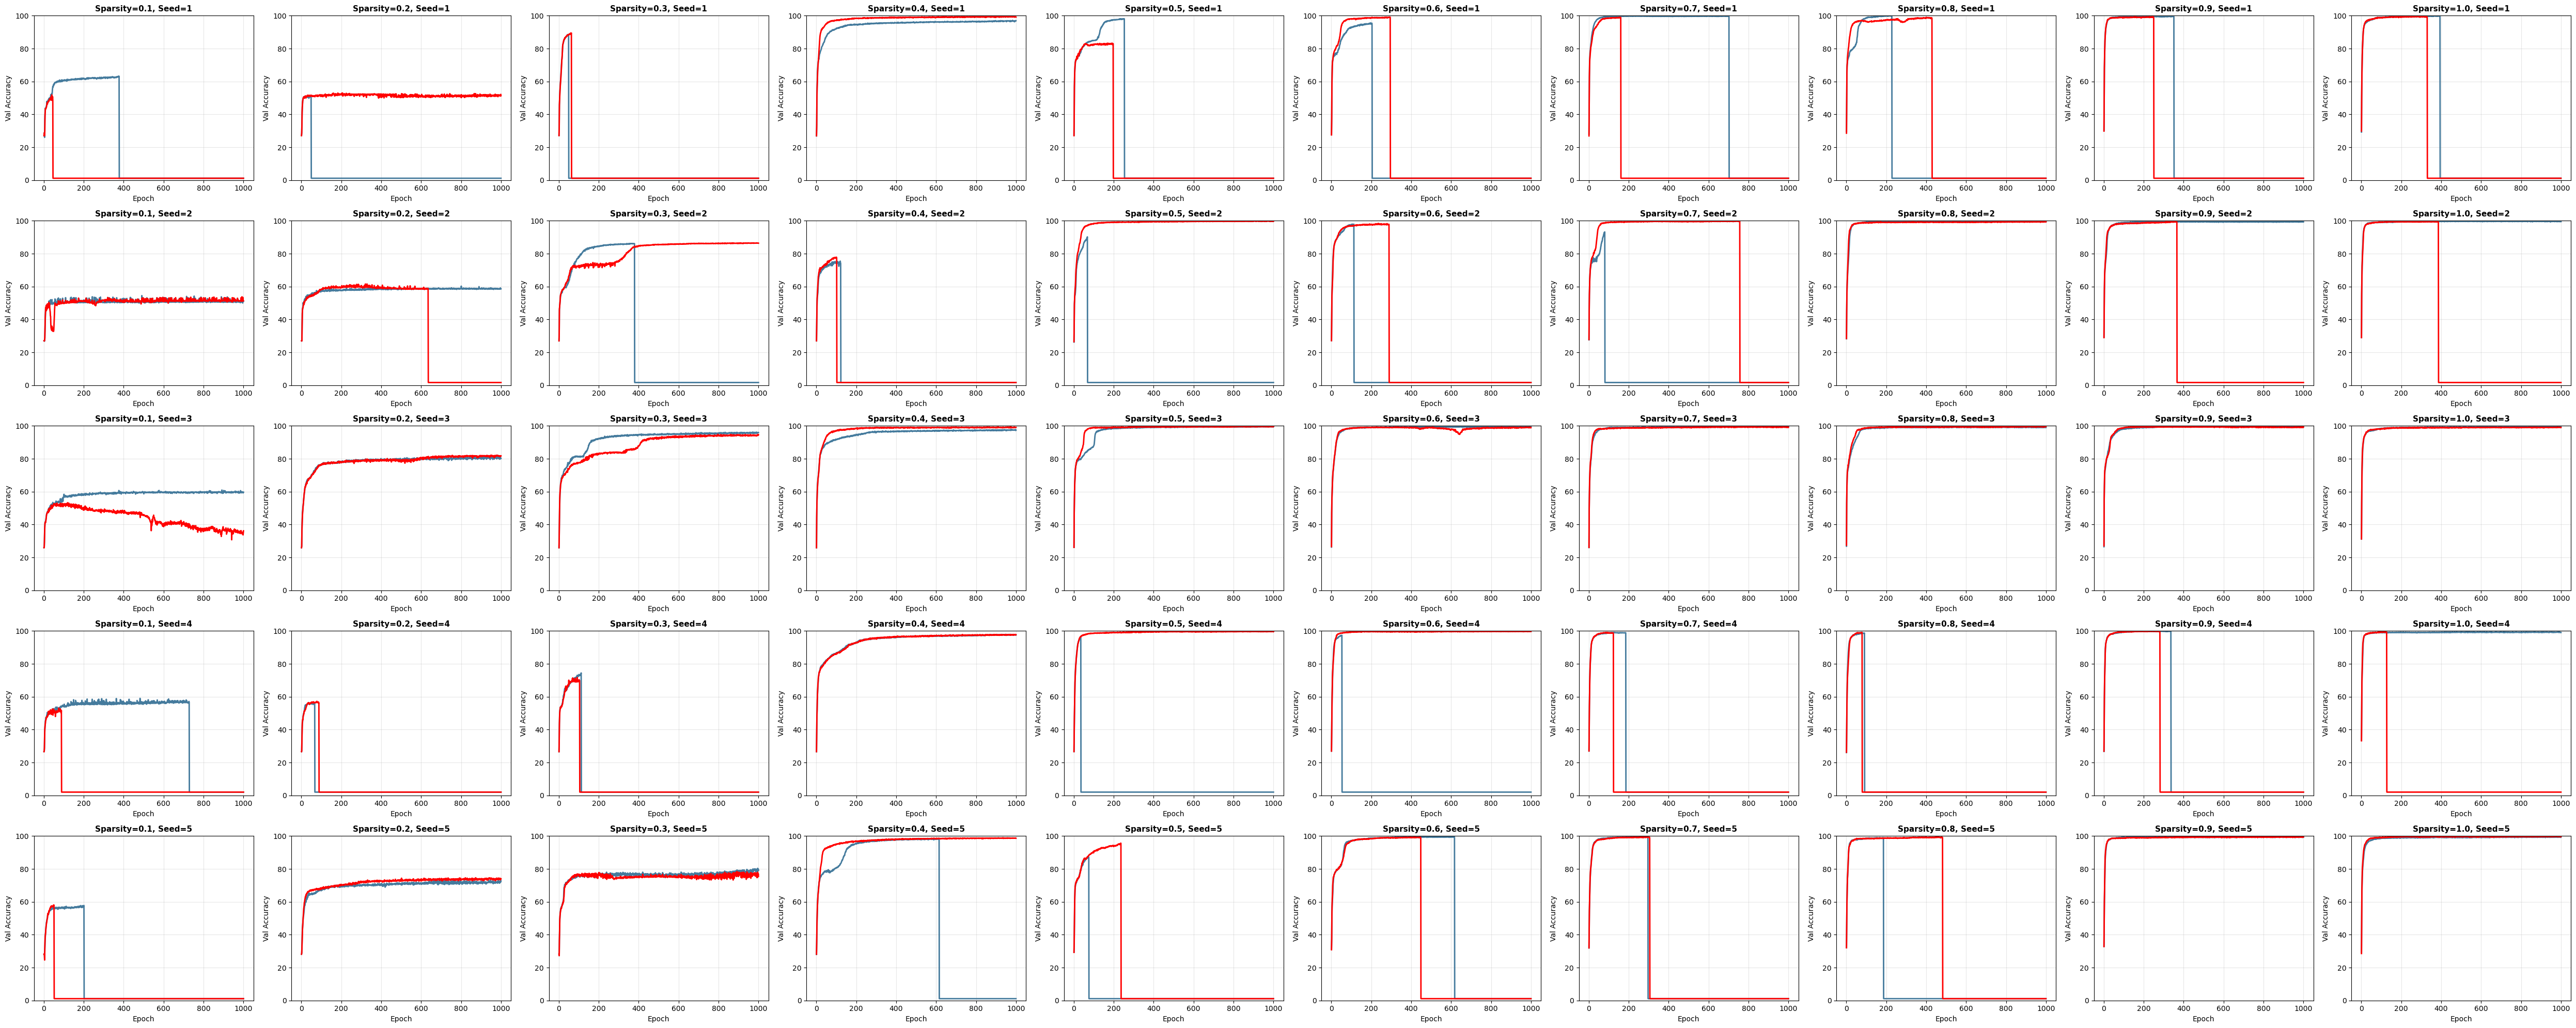

In [ ]:
# Import necessary components
import torch
import numpy as np

# Import from refactored modular structure
from data_generation import GaussianMixtureModel, generate_icl_gmm_data
from datasets import ICLGMMDataset, collate_fn
from models import MatrixTreeMarkovICL
from training import train_model
from evaluation import test_icl

from torch.utils.data import DataLoader
import os
import time

import pickle
import matplotlib.pyplot as plt
import numpy as np

# Define seed and sparsity arrays
seed_array = [1, 2, 3, 4, 5]
sparsity_array = np.arange(0.0, 1.1, 0.1)

# Create figure with subplots
n_seeds = len(seed_array)
n_sparsity = len(sparsity_array)
fig, axes = plt.subplots(n_seeds, n_sparsity, figsize=(5*n_sparsity, 4*n_seeds))

# Ensure axes is 2D array even if only one row or column
if n_seeds == 1:
    axes = axes.reshape(1, -1)
if n_sparsity == 1:
    axes = axes.reshape(-1, 1)

# Loop through seeds and sparsity values
for i, seed in enumerate(seed_array):
    for j, sparsity in enumerate(sparsity_array):
        ax = axes[i, j]
        
        # Construct path
        path = f"/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/rho_all_seed_n_nodes5_nlm0p0_big/{sparsity:.1f}_{seed}/"
        results_path = path + "results.pkl"
        
        try:
            # Load the results
            with open(results_path, "rb") as file:
                data = pickle.load(file)
            
            # Extract components
            history = data['history']
            
            # Plot validation accuracy
            if 'val_acc' in history:
                epochs_plot = range(1, len(history['val_acc']) + 1)
                ax.plot(epochs_plot, history['val_acc'], linewidth=2, color='#457B9D')
                ax.set_xlabel('Epoch', fontsize=10)
                ax.set_ylabel('Val Accuracy', fontsize=10)
                ax.set_title(f'Sparsity={sparsity:.1f}, Seed={seed}', fontsize=11, fontweight='bold')
                ax.grid(True, alpha=0.3)
            else:
                ax.text(0.5, 0.5, 'No val_acc data', ha='center', va='center', transform=ax.transAxes)
                
                ax.set_title(f'Sparsity={sparsity:.1f}, Seed={seed}', fontsize=11, fontweight='bold')
            ax.set_ylim(0, 100)
        except FileNotFoundError:
            ax.text(0.5, 0.5, 'File not found', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'Sparsity={sparsity:.1f}, Seed={seed}', fontsize=11, fontweight='bold')
        except Exception as e:
            ax.text(0.5, 0.5, f'Error: {str(e)[:20]}', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'Sparsity={sparsity:.1f}, Seed={seed}', fontsize=11, fontweight='bold')

        

        # Construct path
        path = f"/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/rho_all_seed_n_nodes5_nlm0p2_big/{sparsity:.1f}_{seed}/"
        results_path = path + "results.pkl"
        
        try:
            # Load the results
            with open(results_path, "rb") as file:
                data = pickle.load(file)
            
            # Extract components
            history = data['history']
            
            # Plot validation accuracy
            if 'val_acc' in history:
                epochs_plot = range(1, len(history['val_acc']) + 1)
                ax.plot(epochs_plot, history['val_acc'], linewidth=2, color='red')
                ax.set_xlabel('Epoch', fontsize=10)
                ax.set_ylabel('Val Accuracy', fontsize=10)
                ax.set_title(f'Sparsity={sparsity:.1f}, Seed={seed}', fontsize=11, fontweight='bold')
                ax.grid(True, alpha=0.3)
            else:
                ax.text(0.5, 0.5, 'No val_acc data', ha='center', va='center', transform=ax.transAxes)
                
                ax.set_title(f'Sparsity={sparsity:.1f}, Seed={seed}', fontsize=11, fontweight='bold')
            ax.set_ylim(0, 100)
        except FileNotFoundError:
            ax.text(0.5, 0.5, 'File not found', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'Sparsity={sparsity:.1f}, Seed={seed}', fontsize=11, fontweight='bold')
        except Exception as e:
            ax.text(0.5, 0.5, f'Error: {str(e)[:20]}', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'Sparsity={sparsity:.1f}, Seed={seed}', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


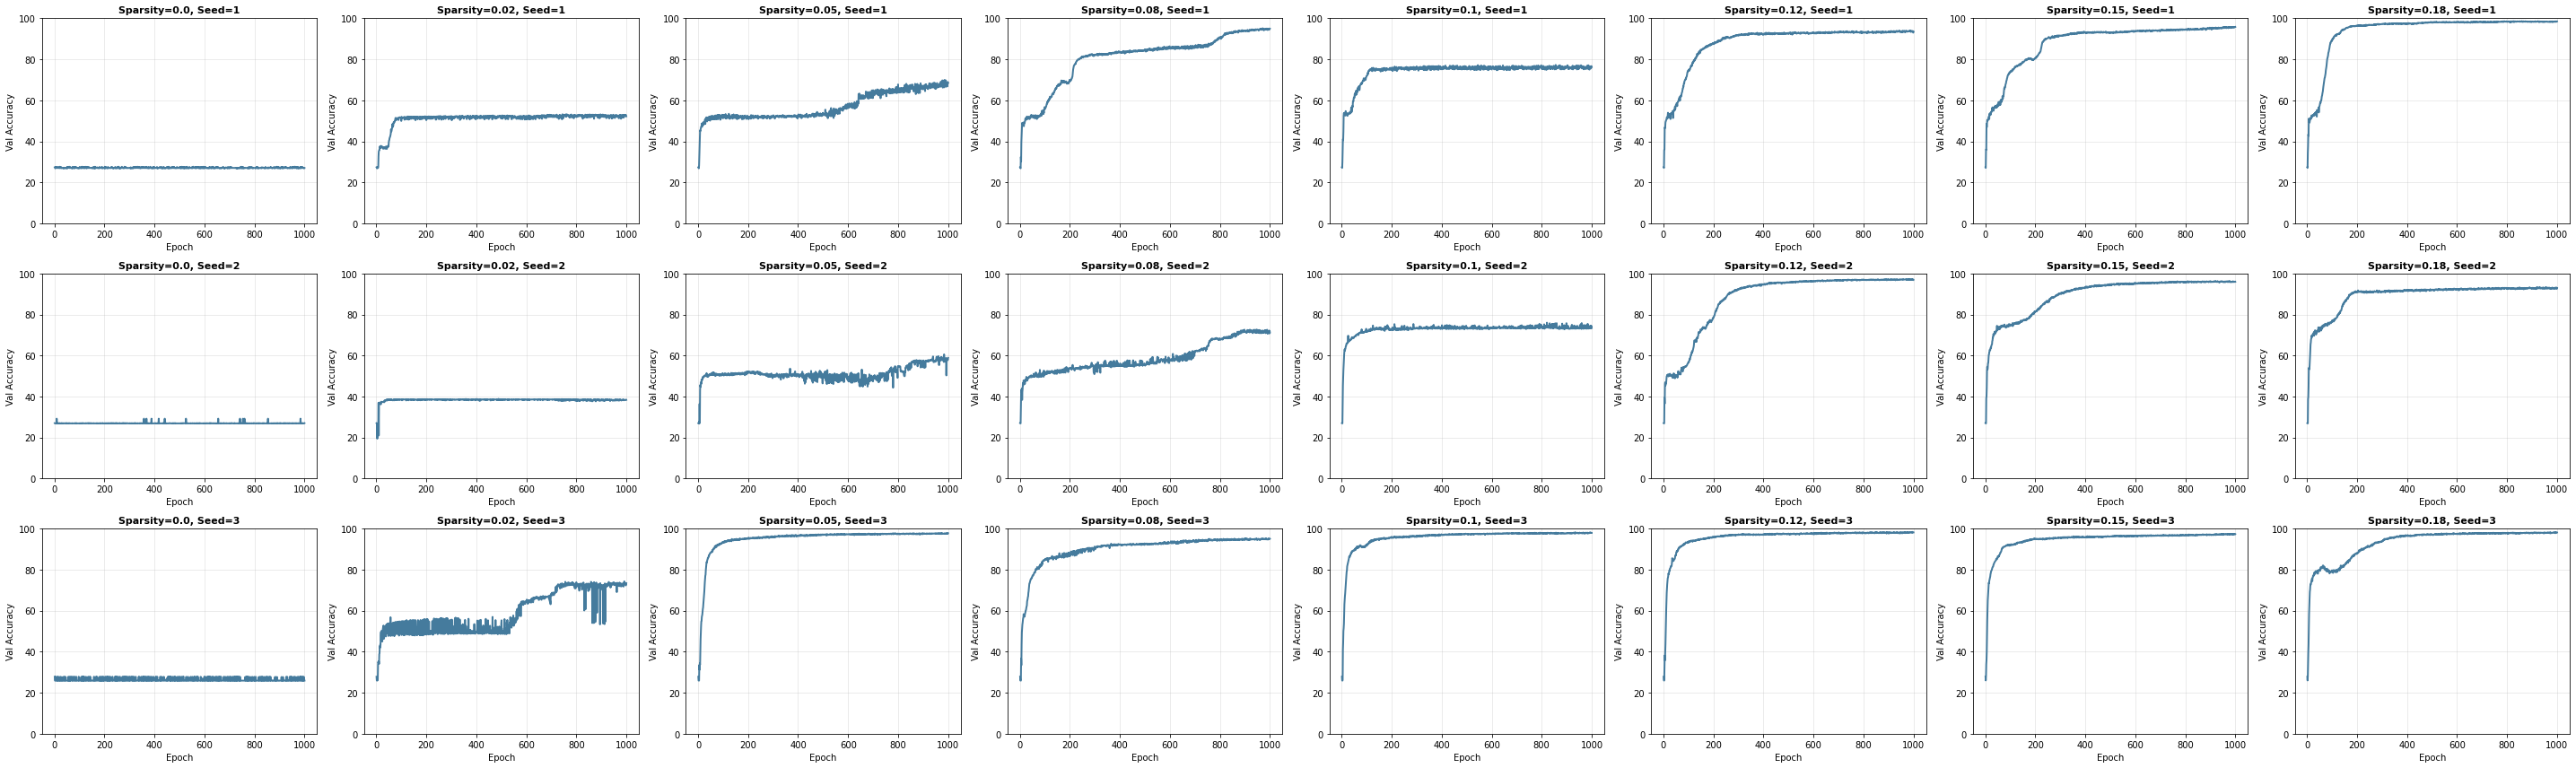

In [4]:
# Import necessary components
import torch
import numpy as np

# Import from refactored modular structure
from data_generation import GaussianMixtureModel, generate_icl_gmm_data
from datasets import ICLGMMDataset, collate_fn
from models import MatrixTreeMarkovICL
from training import train_model
from evaluation import test_icl

from torch.utils.data import DataLoader
import os
import time

import pickle
import matplotlib.pyplot as plt
import numpy as np

# Define seed and sparsity arrays
seed_array = [1, 2, 3]
sparsity_array = np.arange(0.0, 0.2, 0.025)
sparsity_array = [round(s,2) for s in sparsity_array]

# Create figure with subplots
n_seeds = len(seed_array)
n_sparsity = len(sparsity_array)
fig, axes = plt.subplots(n_seeds, n_sparsity, figsize=(5*n_sparsity, 4*n_seeds))

# Ensure axes is 2D array even if only one row or column
if n_seeds == 1:
    axes = axes.reshape(1, -1)
if n_sparsity == 1:
    axes = axes.reshape(-1, 1)

# Loop through seeds and sparsity values
for i, seed in enumerate(seed_array):
    for j, sparsity in enumerate(sparsity_array):
        ax = axes[i, j]
        
        # Construct path
        path = f"/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/rho_all_seed_n_nodes5_nlm_L_3/{sparsity}_{seed}/"
        results_path = path + "results.pkl"
        
        try:
            # Load the results
            with open(results_path, "rb") as file:
                data = pickle.load(file)
            
            # Extract components
            history = data['history']
            
            # Plot validation accuracy
            if 'val_acc' in history:
                epochs_plot = range(1, len(history['val_acc']) + 1)
                ax.plot(epochs_plot, history['val_acc'], linewidth=2, color='#457B9D')
                ax.set_xlabel('Epoch', fontsize=10)
                ax.set_ylabel('Val Accuracy', fontsize=10)
                ax.set_title(f'Sparsity={sparsity}, Seed={seed}', fontsize=11, fontweight='bold')
                ax.grid(True, alpha=0.3)
            else:
                ax.text(0.5, 0.5, 'No val_acc data', ha='center', va='center', transform=ax.transAxes)
                
                ax.set_title(f'Sparsity={sparsity}, Seed={seed}', fontsize=11, fontweight='bold')
            ax.set_ylim(0, 100)
        except FileNotFoundError:
            ax.text(0.5, 0.5, 'File not found', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'Sparsity={sparsity}, Seed={seed}', fontsize=11, fontweight='bold')
        except Exception as e:
            ax.text(0.5, 0.5, f'Error: {str(e)[:20]}', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'Sparsity={sparsity}, Seed={seed}', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


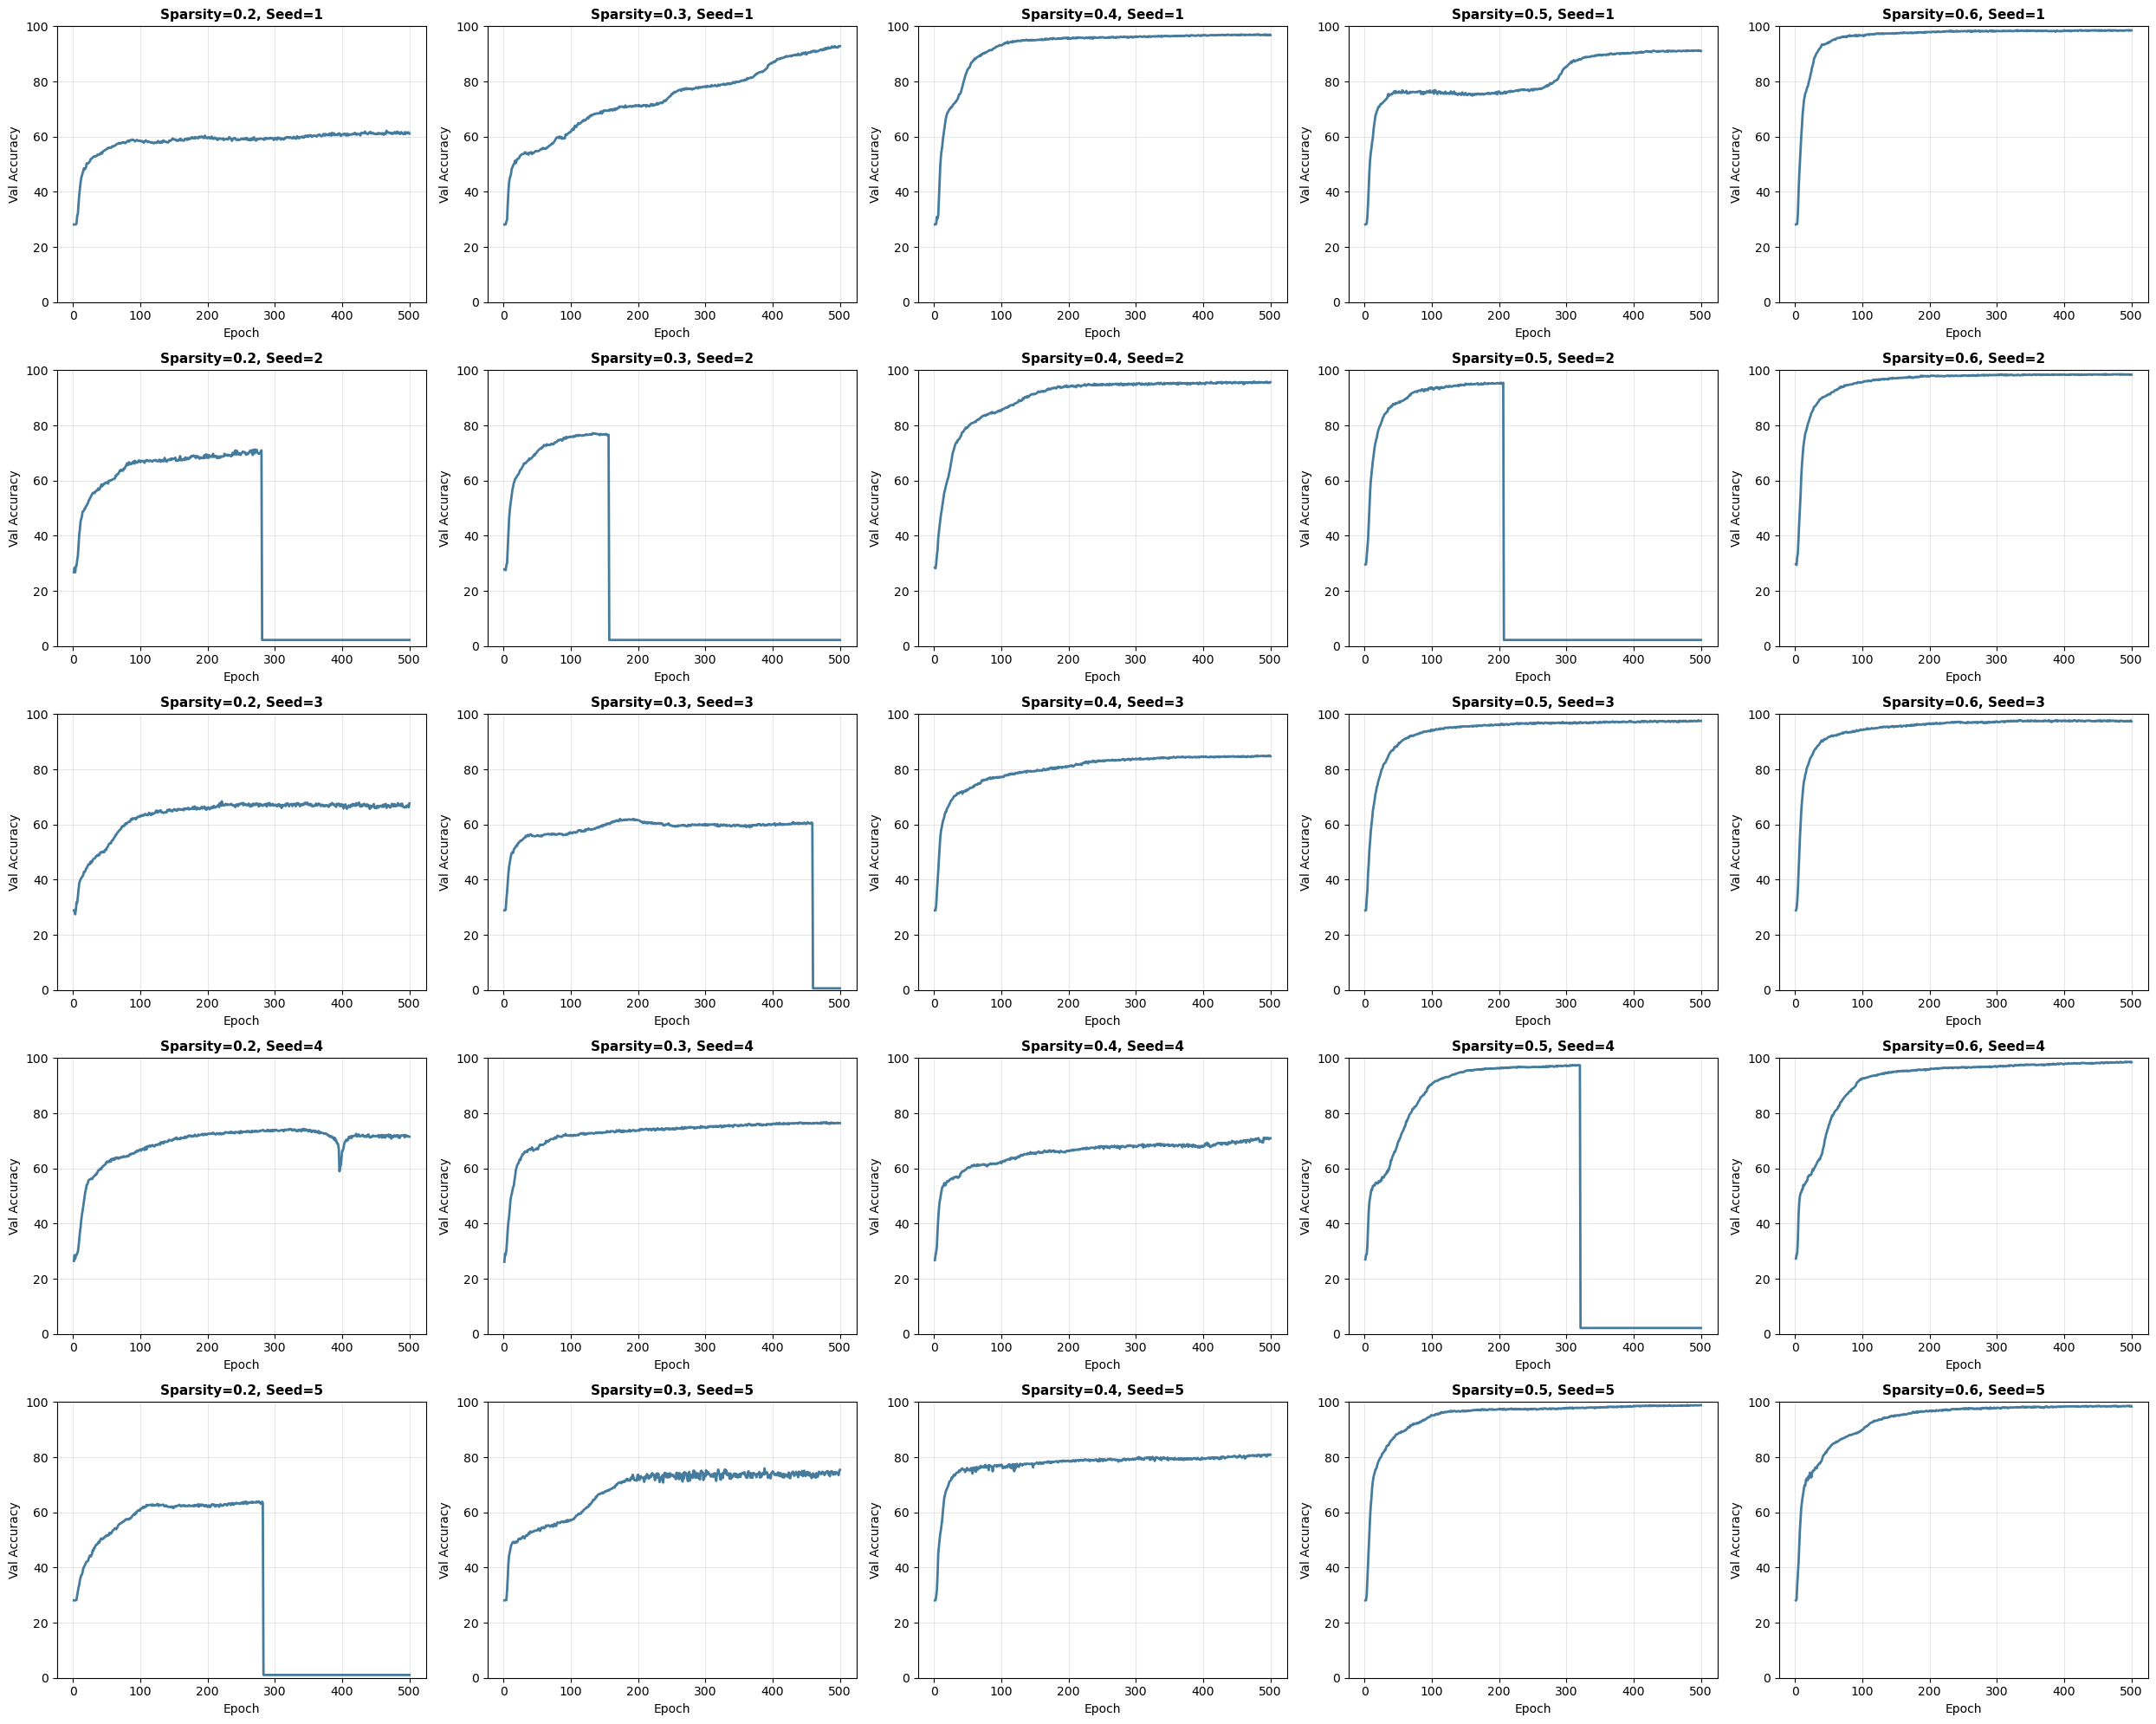

In [28]:
# Import necessary components
import torch
import numpy as np

# Import from refactored modular structure
from data_generation import GaussianMixtureModel, generate_icl_gmm_data
from datasets import ICLGMMDataset, collate_fn
from models import MatrixTreeMarkovICL
from training import train_model
from evaluation import test_icl

from torch.utils.data import DataLoader
import os
import time

import pickle
import matplotlib.pyplot as plt
import numpy as np

# Define seed and sparsity arrays
seed_array = [1, 2, 3, 4, 5]
sparsity_array = np.arange(0.2, 0.7, 0.1)

# Create figure with subplots
n_seeds = len(seed_array)
n_sparsity = len(sparsity_array)
fig, axes = plt.subplots(n_seeds, n_sparsity, figsize=(5*n_sparsity, 4*n_seeds))

# Ensure axes is 2D array even if only one row or column
if n_seeds == 1:
    axes = axes.reshape(1, -1)
if n_sparsity == 1:
    axes = axes.reshape(-1, 1)

# Loop through seeds and sparsity values
for i, seed in enumerate(seed_array):
    for j, sparsity in enumerate(sparsity_array):
        ax = axes[i, j]
        
        # Construct path
        path = f"/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/rho_all_seed_n_nodes5_nlm0p2_15/{sparsity:.1f}_{seed}/"
        results_path = path + "results.pkl"
        
        try:
            # Load the results
            with open(results_path, "rb") as file:
                data = pickle.load(file)
            
            # Extract components
            history = data['history']
            
            # Plot validation accuracy
            if 'val_acc' in history:
                epochs_plot = range(1, len(history['val_acc']) + 1)
                ax.plot(epochs_plot, history['val_acc'], linewidth=2, color='#457B9D')
                ax.set_xlabel('Epoch', fontsize=10)
                ax.set_ylabel('Val Accuracy', fontsize=10)
                ax.set_title(f'Sparsity={sparsity:.1f}, Seed={seed}', fontsize=11, fontweight='bold')
                ax.grid(True, alpha=0.3)
            else:
                ax.text(0.5, 0.5, 'No val_acc data', ha='center', va='center', transform=ax.transAxes)
                
                ax.set_title(f'Sparsity={sparsity:.1f}, Seed={seed}', fontsize=11, fontweight='bold')
            ax.set_ylim(0, 100)
        except FileNotFoundError:
            ax.text(0.5, 0.5, 'File not found', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'Sparsity={sparsity:.1f}, Seed={seed}', fontsize=11, fontweight='bold')
        except Exception as e:
            ax.text(0.5, 0.5, f'Error: {str(e)[:20]}', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'Sparsity={sparsity:.1f}, Seed={seed}', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


In [30]:
np.exp(-2)

0.1353352832366127

In [32]:
torch.log(0.1)

TypeError: log(): argument 'input' (position 1) must be Tensor, not float

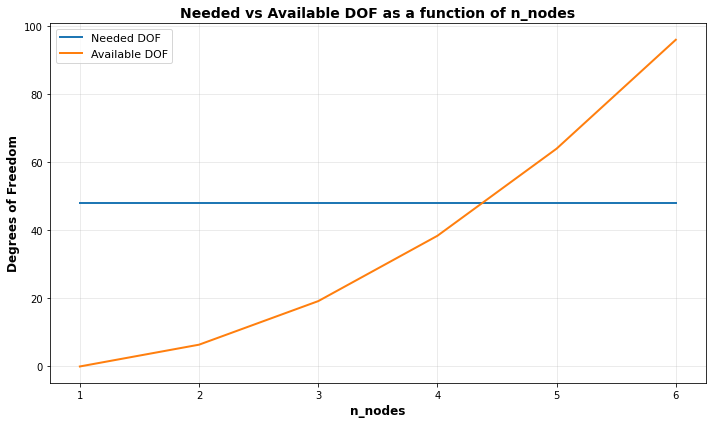

Fixed parameters: DD=2, N=3, L=128
Sparsity parameters: rho_all=0.4, rho_edge=1.0


In [28]:
# Fixed parameters
DD = 2
N = 3

sparsity_rho_all = 0.4  # Adjust based on your actual values
sparsity_rho_edge = 1.0  # Adjust based on your actual values

# Range of n_nodes to plot
n_nodes_range = np.arange(1, 7, 1)

# Calculate needed and available degrees of freedom for each n_nodes
needed_dof = 2 * DD * N * (N+1) * np.ones_like(n_nodes_range)
available_dof = sparsity_rho_all * sparsity_rho_edge * (N+1) * DD * n_nodes_range * (n_nodes_range-1)

# Plot the two curves
plt.figure(figsize=(10, 6))
plt.plot(n_nodes_range, needed_dof, label='Needed DOF', linewidth=2)
plt.plot(n_nodes_range, available_dof, label='Available DOF', linewidth=2)
plt.xlabel('n_nodes', fontsize=12, fontweight='bold')
plt.ylabel('Degrees of Freedom', fontsize=12, fontweight='bold')
plt.title('Needed vs Available DOF as a function of n_nodes', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Fixed parameters: DD={DD}, N={N}, L={L}")
print(f"Sparsity parameters: rho_all={sparsity_rho_all}, rho_edge={sparsity_rho_edge}")


In [27]:
np.arange(0.1, 1.1, 0.1)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [ ]:
8148/3600

2.263333333333333

In [ ]:
15**2

225

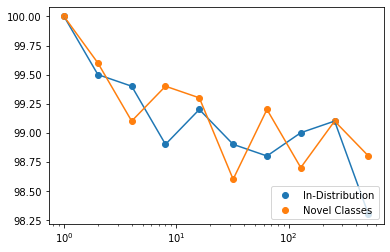

In [ ]:
var_list = [5, 10, 15, 20]
var_list = [5, 10, 15, 20, 25, 30]
var_list = [4, 6, 8, 10, 12]
in_dist_list = []
novel_classes_list = []

var_list = 2**np.arange(0,10,1)
path_base = "/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/L/"

for var in var_list:
    path = path_base + str(var) + "/"
    results_path = path + "results.pkl"
    with open(results_path, "rb") as file:
        data = pickle.load(file)
    results = data['results']
    in_dist_list.append(results['in_dist'])
    novel_classes_list.append(results['novel_classes'])

plt.scatter(var_list, in_dist_list, label='In-Distribution')
plt.scatter(var_list, novel_classes_list, label='Novel Classes')
plt.plot(var_list, in_dist_list)
plt.plot(var_list, novel_classes_list)
plt.xscale('log')
#plt.ylim(0, 101)
plt.legend(loc='lower right')
plt.show()




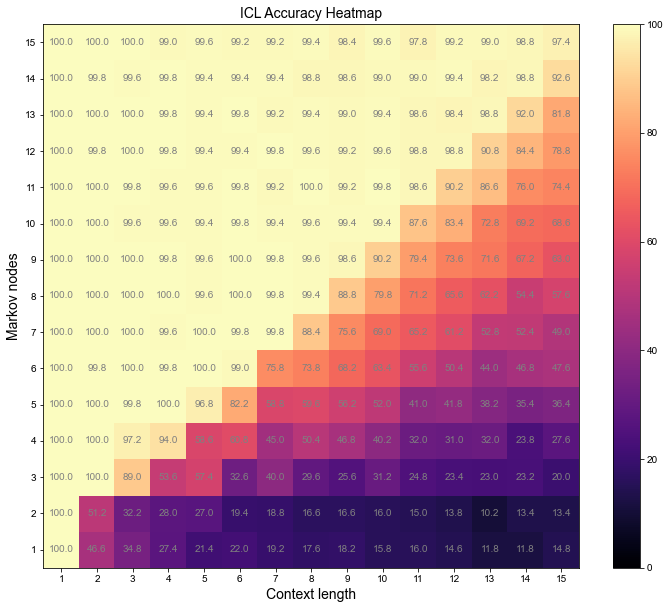

In [56]:
param1_values = [2,4]
param2_values = 2**np.array([4,6,8,10])
path_base = "/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/B_K/"

param1_values = [2,3,4,5,6,7,8,9,10]
param2_values = [2,3,4,5,6,7,8,9,10]
param1_values = np.arange(1,16,1)
param2_values = np.arange(1,16,1)
path_base = "/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/N_n_nodes_verybig_f/"


# param1_values = 2**np.arange(0,8,1)
# param2_values = 2**np.arange(0,11,2)
# path_base = "/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/D_K/"


results_grid = np.zeros((len(param1_values), len(param2_values)))
for i, param1 in enumerate(param1_values):
    for j, param2 in enumerate(param2_values):
        path = path_base + str(param1) + "_" + str(param2) + "/"
        results_path = path + "results.pkl"
        with open(results_path, "rb") as file:
            data = pickle.load(file)
        results = data['results']
        history = data['history']
        icl_acc = [val for val in history['icl_acc'] if val is not None]
        results_grid[i, j] = icl_acc[-1]
        #results_grid[i, j] = results['in_dist']
        #results_grid[i, j] = history['train_acc'][-1]


# plot
fig, ax = plt.subplots(figsize=(12, 10))
fs = 14

im = ax.imshow(results_grid.T, cmap='magma', aspect='auto', origin='lower', vmin = 0, vmax = 100)
plt.colorbar(im, ax=ax)
ax.set_xlabel('Context length', fontsize=fs)
ax.set_ylabel('Markov nodes', fontsize=fs)
# ax.set_xlabel('D')
# ax.set_ylabel('K')
ax.set_yticks(range(len(param2_values)), param2_values)
ax.set_xticks(range(len(param1_values)), param1_values)
ax.set_title('ICL Accuracy Heatmap', fontsize=fs)

# Add text annotations for each cell
for i in range(len(param1_values)):
    for j in range(len(param2_values)):
        text = ax.text(i, j, f'{results_grid[i, j]:.1f}',
                       ha="center", va="center", color="gray", fontsize=10)

plt.show()


In [ ]:
(8*8)*9*128 + 8*8

73792

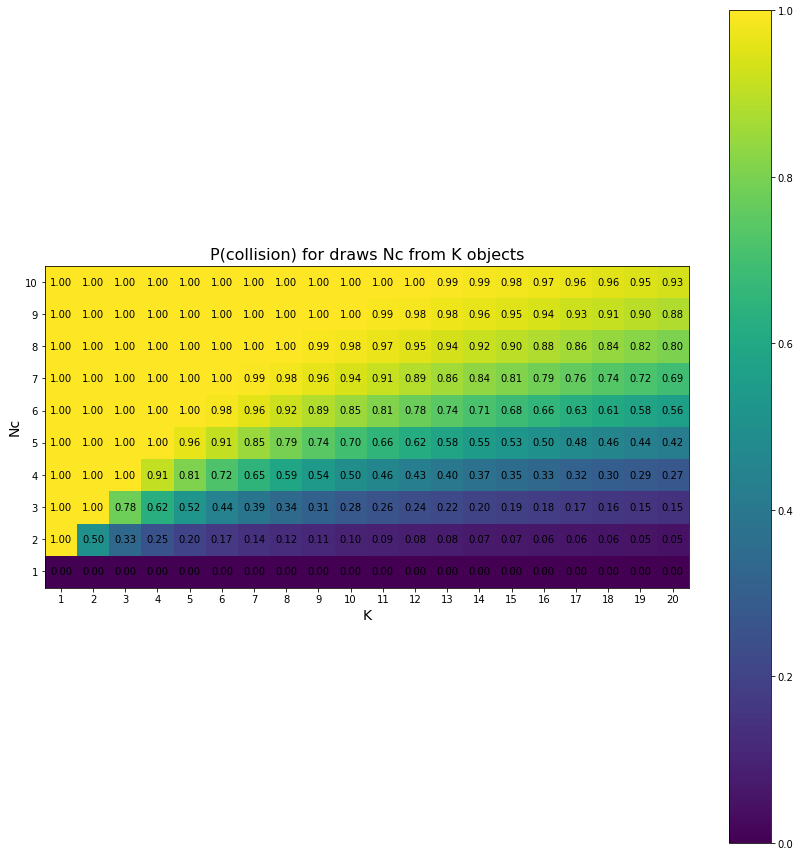

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def p_collision_exact(K, Nc):
    """Probability of at least one collision when drawing Nc times from K objects."""
    if Nc > K:
        return 1.0
    p_no = 1.0
    for i in range(Nc):
        p_no *= (K - i) / K
    return 1.0 - p_no

# ranges
max_K = 20
max_Nc = 10

# table[Nc-1, K-1] = p(collision)
table = np.zeros((max_Nc, max_K))
for Nc in range(1, max_Nc+1):
    for K in range(1, max_K+1):
        table[Nc-1, K-1] = p_collision_exact(K, Nc)

# plot
fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(table, origin='lower')

# write numbers on each pixel
for i in range(max_Nc):
    for j in range(max_K):
        ax.text(j, i, f"{table[i, j]:.2f}", ha="center", va="center")

# axis labels and ticks
ax.set_xlabel("K", fontsize=14)
ax.set_ylabel("Nc", fontsize=14)
ax.set_xticks(range(max_K))
ax.set_xticklabels(range(1, max_K+1))
ax.set_yticks(range(max_Nc))
ax.set_yticklabels(range(1, max_Nc+1))

plt.title("P(collision) for draws Nc from K objects", fontsize=16)
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()


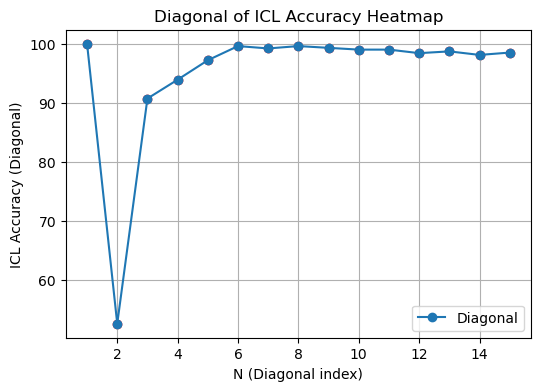

In [ ]:
# Plot diagonal of results_grid as scatter and lines
diagonal = np.diag(results_grid)
plt.figure(figsize=(6,4))
plt.plot(param1_values[:len(diagonal)], diagonal, marker='o', linestyle='-', label='Diagonal')
plt.scatter(param1_values[:len(diagonal)], diagonal, color='red')
plt.xlabel('N (Diagonal index)')
plt.ylabel('ICL Accuracy (Diagonal)')
plt.title('Diagonal of ICL Accuracy Heatmap')
plt.legend()
plt.grid(True)
plt.show()

# Simplex plot


In [42]:
# Import necessary components
import torch
import numpy as np

# Import from refactored modular structure
from data_generation import GaussianMixtureModel, generate_icl_gmm_data
from datasets import ICLGMMDataset, collate_fn
from models import MatrixTreeMarkovICL
from training import train_model
from evaluation import test_icl

from torch.utils.data import DataLoader
import os
import time

path = "/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/N_n_nodes_small/2_2/"


import pickle
import matplotlib.pyplot as plt
import numpy as np

# Load the results
results_path = path + "results.pkl"
with open(results_path, "rb") as file:
    data = pickle.load(file)

# Extract components
results = data['results']
history = data['history']
params = data['params']
execution_time = data['execution_time']

# Assuming you have the model parameters
model = MatrixTreeMarkovICL(
    n_nodes=params['n_nodes'], 
    z_dim=params['D'], 
    L=params['L'], 
    N=params['N']
)

# Load the saved weights
model_path = path + 'model.pt'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.load_state_dict(torch.load(model_path, map_location=device))

model.to(device)
model.eval()

gmm = GaussianMixtureModel(
    K=params['K'], 
    D=params['D'], 
    L=params['L'], 
    epsilon=params['epsilon'], 
    seed=params['seed'], 
    offset=params['offset']
)
train_data = generate_icl_gmm_data(gmm, params['train_samples'], params['N'], 
                                   novel_classes=False, exact_copy=params['exact_copy'], 
                                   B=params['B'], L=params['L'], shuffle_context=params['shuffle_context'], min_max_choice=params['min_max_choice'], unique_labels = params['unique_labels'])

train_loader = DataLoader(ICLGMMDataset(train_data), batch_size=params['batch_size'],
                          shuffle=True, collate_fn=collate_fn)


  Initialized ICL Attention model (L=256 classes, attention over 2 context items)
  Label modulation: False
  Base rates learnable: True
  Base mask value: 0.0
  Sparsity K: rho_edge=1.000, rho_all=1.000
  Sparsity base_W: rho_edge=1.000
  K_params sparsity: 0.000 (12/12 active)
  base_W sparsity: 0.000 (4/4 active)
  Parameters: 20


/Users/csfloyd/opt/anaconda3/lib/python3.8/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


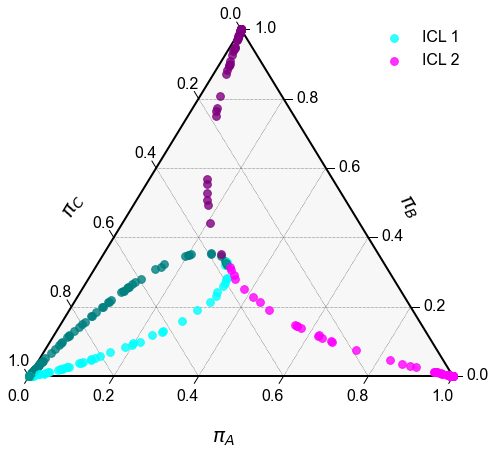

In [40]:
import ternary
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

plt.rcParams['font.family'] = 'Arial'

# Loop to collect n_samples points
n_samples = 500
p_steady_list = []
targets_list = []
class_list = []
min_max_list = []
model.eval()
with torch.no_grad():
    for i in range(n_samples):
        # Get a single example from the training dataset
        z_seq, labels, targets = train_loader.dataset[i]
        
        # Add batch dimension and move to device
        z_seq = z_seq.unsqueeze(0).to(device)  # Shape: (1, N+1, D)
        labels = labels.unsqueeze(0).to(device)  # Shape: (1, N)
        targets = targets.unsqueeze(0).to(device).long()  # Shape: (1,)
        # print(targets)
        # print(labels)
        # Find which element of labels equals the target
        matching_indices = (labels[0] == targets[0]).nonzero(as_tuple=True)[0]
        if len(matching_indices) > 0:
            class_idx = matching_indices[0].item()
        else:
            class_idx = -1  # No matching class found
        class_list.append(class_idx)
        
        # Flatten z_seq as the model expects
        z_flat = z_seq.reshape(1, -1)  # Shape: (1, (N+1)*D)
        
        # Compute the rate matrix K
        W_mat = model.compute_rate_matrix_W(z_flat)
        p_steady = model.direct_solve_steady_state(W_mat)  # default

        z_array = np.array(z_flat)[0]
        # if np.max(np.array(p_steady)) <= 0.6:
        #     print(z_array)

        if z_array[class_idx] > z_array[1-class_idx]:
            min_max_list.append(1)
        else:
            min_max_list.append(0)

        # Store results
        p_steady_list.append(p_steady.cpu())
        targets_list.append(targets.cpu())

# Convert lists to tensors for easier manipulation
p_steady_all = torch.cat(p_steady_list, dim=0)  # Shape: (n_samples, n_nodes)
targets_all = torch.cat(targets_list, dim=0)  # Shape: (n_samples,)


scale = 1
fs = 16
offset = 0.15

fig, ax = plt.subplots(figsize= 1 * np.array([7, 6]))
#fig.set_size_inches(5, 5)
tax = ternary.TernaryAxesSubplot(scale=scale, ax=ax)
#tax.set_title("Steady State Distribution by Context Class", fontsize=fs)
tax.boundary(linewidth=2.0)
tax.gridlines(multiple=0.2, color="black")


ternary_points = (p_steady_all.numpy() * scale).tolist()

# Get unique classes for coloring
class_array = np.array(class_list)
unique_classes = np.unique(class_array)
colors = ['cyan', 'magenta', 'yellow', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan']

coloff = 0.5
def adjust_lightness(color, amount=0.5):
    """
    Lightens or darkens the given color.
    amount > 1.0 makes it lighter, amount < 1.0 makes it darker.
    """
    try:
        c = mcolors.cnames[color]
    except:
        c = color
    c = mcolors.to_rgb(c)
    # Convert to HSL (Hue, Saturation, Lightness)
    c = np.array(mcolors.rgb_to_hsv(c))
    # Adjust the lightness (V in HSV)
    c[2] = min(1.0, c[2] * amount)
    return mcolors.hsv_to_rgb(c)

# Plot points colored by class
for idx, class_idx in enumerate(unique_classes):
    mask = (class_array == class_idx)
    # Get original indices where mask is True
    original_indices = np.where(mask)[0]
    
    for orig_idx in original_indices:
        point = ternary_points[orig_idx]
        marker_shape = 's' if min_max_list[orig_idx] == 0 else 'o'
        amt = 1-coloff if min_max_list[orig_idx] == 0 else 1+coloff   
        color = adjust_lightness(colors[idx], amt)
        # Only add label for first point of each class
        label = f"ICL {int(class_idx+1)}" if orig_idx == original_indices[0] else ""
        tax.scatter([point], marker='o', color=color, 
                    label=label, s=60, alpha=0.8, zorder=10)

tax.ticks(axis='lbr', multiple=0.2, linewidth=1, tick_formats="%.1f", offset=0.02, fontsize=fs)
tax.bottom_axis_label(r"$\pi_A$", fontsize=fs+4, offset=offset)
tax.right_axis_label(r"$\pi_B$", fontsize=fs+4, offset=offset)
tax.left_axis_label(r"$\pi_C$", fontsize=fs+4, offset=offset)
tax.get_axes().axis('off')
tax.legend(fontsize=fs, frameon=False)

plt.tight_layout()
plt.show()

In [43]:
# ============================================================================
# IMPORTS
# ============================================================================
import plotly.graph_objects as go
import numpy as np


# ============================================================================
# CONFIGURATION
# ============================================================================

# Index pairs for K_params access
INDEX_PAIRS = {
    'one': [0, 2],
    'two': [2, 1],
    'three': [0, 1],
    'four': [1, 2],
    'five': [1, 0],
    'six': [2, 0]
}

# Color scheme
VECTOR_COLORS = {
    'A': 'red',
    'B': 'blue',
    'C': 'green'
}

PLANE_COLORS = {
    'ICL1': 'darkturquoise',
    'ICL2': 'magenta'
}

# Visualization parameters
MAX_RANGE = 3
SHOW_LEGEND = False
COLOFF = 0.3  # Color offset for lightness adjustment


# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def add_arrow(fig, start, end, color, name, width=5, sizeref=0.6, showlegend=False):
    """Add a 3D arrow to the figure with a cone at the tip."""
    # Arrow shaft
    fig.add_trace(go.Scatter3d(
        x=[start[0], end[0]],
        y=[start[1], end[1]],
        z=[start[2], end[2]],
        mode='lines',
        line=dict(color=color, width=width),
        name=name,
        showlegend=showlegend if name else False
    ))
    
    # Arrowhead cone
    fig.add_trace(go.Cone(
        x=[end[0]], y=[end[1]], z=[end[2]],
        u=[end[0] - start[0]],
        v=[end[1] - start[1]],
        w=[end[2] - start[2]],
        colorscale=[[0, color], [1, color]],
        showscale=False,
        sizemode='absolute',
        sizeref=sizeref,
        showlegend=False
    ))


def get_k_param(model, key):
    """Extract K_params for a given index pair."""
    idx = INDEX_PAIRS[key]
    return model.K_params[idx[0], idx[1], :].detach().numpy()


def add_plane(fig, v1, v2, color, name, max_range, showlegend=False):
    """Add a semi-transparent plane to the figure."""
    t1 = np.linspace(-max_range, max_range, 20)
    t2 = np.linspace(-max_range, max_range, 20)
    T1, T2 = np.meshgrid(t1, t2)
    
    X = T2 * v2[0] + T1 * v1[0]
    Y = T2 * v2[1] + T1 * v1[1]
    Z = T2 * v2[2] + T1 * v1[2]
    
    fig.add_trace(go.Surface(
        x=X, y=Y, z=Z,
        opacity=0.1,
        colorscale=[[0, color], [1, color]],
        showscale=False,
        name=name,
        showlegend=showlegend
    ))


# ============================================================================
# COMPUTE VECTORS AND PROBABILITIES
# ============================================================================

# Compute combined vectors from K_params
A1 = get_k_param(model, 'one') + get_k_param(model, 'two')
A2 = get_k_param(model, 'three') + get_k_param(model, 'four')
A3 = get_k_param(model, 'one') + get_k_param(model, 'three')

B1 = get_k_param(model, 'five') + get_k_param(model, 'one')
B2 = get_k_param(model, 'four') + get_k_param(model, 'six')
B3 = get_k_param(model, 'four') + get_k_param(model, 'five')

C1 = get_k_param(model, 'six') + get_k_param(model, 'three')
C2 = get_k_param(model, 'five') + get_k_param(model, 'two')
C3 = get_k_param(model, 'six') + get_k_param(model, 'two')

# Organize vectors
vectors = {
    'A1': A1, 'A2': A2, 'A3': A3,
    'B1': B1, 'B2': B2, 'B3': B3,
    'C1': C1, 'C2': C2, 'C3': C3
}

# Compute class probabilities
piA = np.exp(z_flat @ A1) + np.exp(z_flat @ A2) + np.exp(z_flat @ A3)
piB = np.exp(z_flat @ B1) + np.exp(z_flat @ B2) + np.exp(z_flat @ B3)
piC = np.exp(z_flat @ C1) + np.exp(z_flat @ C2) + np.exp(z_flat @ C3)

Z = piA + piB + piC
piAf = (piA / Z).item()
piBf = (piB / Z).item()
piCf = (piC / Z).item()

print(f"Class probabilities: [A: {piAf:.4f}, B: {piBf:.4f}, C: {piCf:.4f}]")


# ============================================================================
# INITIALIZE 3D FIGURE
# ============================================================================

fig = go.Figure()
origin = np.array([0, 0, 0])


# ============================================================================
# ADD VECTOR ARROWS
# ============================================================================

for idx, (name, vec) in enumerate(vectors.items()):
    letter = name[0]
    color = VECTOR_COLORS[letter]
    
    # Show legend only for first vector of each group (A, B, C)
    display_name = letter if idx % 3 == 0 else None
    showlegend = (idx % 3 == 0) and SHOW_LEGEND
    
    add_arrow(fig, origin, 0.1 * vec, color, display_name, 
              width=5, sizeref=0.4, showlegend=showlegend)


# ============================================================================
# ADD GEOMETRIC ELEMENTS (PLANES AND LINES)
# ============================================================================

# Add ICL planes
add_plane(fig, 
          v1=np.array([1, 0, 1]), 
          v2=np.array([0, 1, 0]), 
          color=PLANE_COLORS['ICL1'], 
          name='ICL 1', 
          max_range=MAX_RANGE,
          showlegend=SHOW_LEGEND)

add_plane(fig, 
          v1=np.array([0, 1, 1]), 
          v2=np.array([1, 0, 0]), 
          color=PLANE_COLORS['ICL2'], 
          name='ICL 2', 
          max_range=MAX_RANGE,
          showlegend=SHOW_LEGEND)

# Add line through origin and (1,1,1)
t_line = np.linspace(-MAX_RANGE, MAX_RANGE, 100)
line_direction = np.array([1, 1, 1])

fig.add_trace(go.Scatter3d(
    x=t_line * line_direction[0],
    y=t_line * line_direction[1],
    z=t_line * line_direction[2],
    mode='lines',
    line=dict(color='black', width=6),
    name='Line (1,1,1)',
    showlegend=SHOW_LEGEND
))


# ============================================================================
# ADD DATA POINTS FROM TRAIN LOADER
# ============================================================================

scatter_x, scatter_y, scatter_z = [], [], []
point_colors = []

for i in range(100):
    # Get batch data
    z_seq, labels, targets = train_loader.dataset[i]
    z_seq = z_seq.unsqueeze(0).to(device)
    z_flat = z_seq.reshape(1, -1)
    
    # Extract first 3 coordinates
    scatter_x.append(z_flat[0, 0].item())
    scatter_y.append(z_flat[0, 1].item())
    scatter_z.append(z_flat[0, 2].item())
    
    # Determine color based on class matching
    z_array = np.array(z_flat)[0]
    class_dominant = 0 if z_array[class_idx] > z_array[1 - class_idx] else 1
    lightness_amt = 1 - COLOFF if class_dominant == 0 else 1 + COLOFF
    
    if targets.item() == labels[0].item():
        color = adjust_lightness(PLANE_COLORS['ICL1'], lightness_amt)
    elif targets.item() == labels[1].item():
        color = adjust_lightness(PLANE_COLORS['ICL2'], lightness_amt)
    
    point_colors.append(color)
    
    # Add line from origin to data point
    vec = z_flat[0, 0:3].detach().numpy()
    t = np.linspace(0, 1, 100)
    
    fig.add_trace(go.Scatter3d(
        x=t * vec[0],
        y=t * vec[1],
        z=t * vec[2],
        mode='lines',
        opacity = 1,
        line=dict(color=[color for _ in range(len(t))], width=1),
        showlegend=False
    ))

# Add scatter plot of data points
fig.add_trace(go.Scatter3d(
    x=scatter_x, y=scatter_y, z=scatter_z,
    mode='markers',
    marker=dict(size=4, color=point_colors, opacity=1),
    name='Data pts'
))


# ============================================================================
# CONFIGURE LAYOUT AND DISPLAY
# ============================================================================

fig.update_layout(
    scene=dict(
        xaxis_title="z<sub>1</sub>",
        yaxis_title="z<sub>2</sub>",
        zaxis_title="z<sub>q</sub>",
        xaxis=dict(range=[-MAX_RANGE, MAX_RANGE], showgrid=True, showbackground=False, gridcolor="whitesmoke"),
        yaxis=dict(range=[-MAX_RANGE, MAX_RANGE], showgrid=True, showbackground=False, gridcolor="whitesmoke"),
        zaxis=dict(range=[-MAX_RANGE, MAX_RANGE], showgrid=True, showbackground=False, gridcolor="whitesmoke"),
        aspectmode='cube',
        camera=dict(eye=dict(x=-1.5, y=-1.2, z=-1)),
        bgcolor='white'
    ),
    width=1000,
    height=800,
    showlegend=SHOW_LEGEND,
    margin=dict(l=0, r=0, t=0, b=0), 
    font=dict(family="Arial, sans-serif", size=14)
)

fig.show()

IndexError: index 2 is out of bounds for dimension 1 with size 2

In [49]:
# ============================================================================
# IMPORTS
# ============================================================================
import plotly.graph_objects as go
import numpy as np


# ============================================================================
# CONFIGURATION
# ============================================================================

# Set number of states (2 or 3)
NUM_STATES = 2  # Change to 2 for 2-state case

# Index pairs for K_params access
INDEX_PAIRS = {
    'one': [0, 2],
    'two': [2, 1],
    'three': [0, 1],
    'four': [1, 2],
    'five': [1, 0],
    'six': [2, 0]
}

# Color scheme
VECTOR_COLORS = {
    'A': 'red',
    'B': 'blue',
    'C': 'green'
}

PLANE_COLORS = {
    'ICL1': 'darkturquoise',
    'ICL2': 'magenta'
}

# Visualization parameters
MAX_RANGE = 3
SHOW_LEGEND = False
COLOFF = 0.3  # Color offset for lightness adjustment


# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def add_arrow(fig, start, end, color, name, width=5, sizeref=0.6, showlegend=False):
    """Add a 3D arrow to the figure with a cone at the tip."""
    # Arrow shaft
    fig.add_trace(go.Scatter3d(
        x=[start[0], end[0]],
        y=[start[1], end[1]],
        z=[start[2], end[2]],
        mode='lines',
        line=dict(color=color, width=width),
        name=name,
        showlegend=showlegend if name else False
    ))
    
    # Arrowhead cone
    fig.add_trace(go.Cone(
        x=[end[0]], y=[end[1]], z=[end[2]],
        u=[end[0] - start[0]],
        v=[end[1] - start[1]],
        w=[end[2] - start[2]],
        colorscale=[[0, color], [1, color]],
        showscale=False,
        sizemode='absolute',
        sizeref=sizeref,
        showlegend=False
    ))


def get_k_param(model, key):
    """Extract K_params for a given index pair."""
    idx = INDEX_PAIRS[key]
    return model.K_params[idx[0], idx[1], :].detach().numpy()


def add_plane(fig, v1, v2, color, name, max_range, showlegend=False):
    """Add a semi-transparent plane to the figure."""
    t1 = np.linspace(-max_range, max_range, 20)
    t2 = np.linspace(-max_range, max_range, 20)
    T1, T2 = np.meshgrid(t1, t2)
    
    X = T2 * v2[0] + T1 * v1[0]
    Y = T2 * v2[1] + T1 * v1[1]
    Z = T2 * v2[2] + T1 * v1[2]
    
    fig.add_trace(go.Surface(
        x=X, y=Y, z=Z,
        opacity=0.1,
        colorscale=[[0, color], [1, color]],
        showscale=False,
        name=name,
        showlegend=showlegend
    ))


# ============================================================================
# COMPUTE VECTORS AND PROBABILITIES
# ============================================================================

if NUM_STATES == 2:
    # 2-state case: simple K_params extraction
    one_inds = [0, 1]
    two_inds = [1, 0]
    A = model.K_params[one_inds[0], one_inds[1], :].detach().numpy()
    B = model.K_params[two_inds[0], two_inds[1], :].detach().numpy()
    
    vectors = {
        'A': A,
        'B': B
    }
    
elif NUM_STATES == 3:
    # 3-state case: combined vectors from K_params
    A1 = get_k_param(model, 'one') + get_k_param(model, 'two')
    A2 = get_k_param(model, 'three') + get_k_param(model, 'four')
    A3 = get_k_param(model, 'one') + get_k_param(model, 'three')
    
    B1 = get_k_param(model, 'five') + get_k_param(model, 'one')
    B2 = get_k_param(model, 'four') + get_k_param(model, 'six')
    B3 = get_k_param(model, 'four') + get_k_param(model, 'five')
    
    C1 = get_k_param(model, 'six') + get_k_param(model, 'three')
    C2 = get_k_param(model, 'five') + get_k_param(model, 'two')
    C3 = get_k_param(model, 'six') + get_k_param(model, 'two')
    
    vectors = {
        'A1': A1, 'A2': A2, 'A3': A3,
        'B1': B1, 'B2': B2, 'B3': B3,
        'C1': C1, 'C2': C2, 'C3': C3
    }

# Compute class probabilities
if NUM_STATES == 2:
    piA = np.exp(z_flat @ vectors['A'])
    piB = np.exp(z_flat @ vectors['B'])
    Z = piA + piB
    piAf = (piA / Z).item()
    piBf = (piB / Z).item()
    print(f"Class probabilities: [A: {piAf:.4f}, B: {piBf:.4f}]")
    
elif NUM_STATES == 3:
    piA = np.exp(z_flat @ vectors['A1']) + np.exp(z_flat @ vectors['A2']) + np.exp(z_flat @ vectors['A3'])
    piB = np.exp(z_flat @ vectors['B1']) + np.exp(z_flat @ vectors['B2']) + np.exp(z_flat @ vectors['B3'])
    piC = np.exp(z_flat @ vectors['C1']) + np.exp(z_flat @ vectors['C2']) + np.exp(z_flat @ vectors['C3'])
    Z = piA + piB + piC
    piAf = (piA / Z).item()
    piBf = (piB / Z).item()
    piCf = (piC / Z).item()
    print(f"Class probabilities: [A: {piAf:.4f}, B: {piBf:.4f}, C: {piCf:.4f}]")


# ============================================================================
# INITIALIZE 3D FIGURE
# ============================================================================

fig = go.Figure()
origin = np.array([0, 0, 0])


# ============================================================================
# ADD VECTOR ARROWS
# ============================================================================

for idx, (name, vec) in enumerate(vectors.items()):
    letter = name[0]
    color = VECTOR_COLORS[letter]
    
    if NUM_STATES == 2:
        # For 2-state: show legend and use names 'A' and 'B'
        display_name = name
        showlegend = SHOW_LEGEND
    else:
        # For 3-state: show legend only for first vector of each group (A, B, C)
        display_name = letter if idx % 3 == 0 else None
        showlegend = (idx % 3 == 0) and SHOW_LEGEND

    vec_scale = 0.5
    add_arrow(fig, origin, vec_scale * vec, color, display_name, 
              width=5, sizeref=0.4, showlegend=showlegend)


# ============================================================================
# ADD GEOMETRIC ELEMENTS (PLANES AND LINES)
# ============================================================================

# Add ICL planes
add_plane(fig, 
          v1=np.array([1, 0, 1]), 
          v2=np.array([0, 1, 0]), 
          color=PLANE_COLORS['ICL1'], 
          name='ICL 1', 
          max_range=MAX_RANGE,
          showlegend=SHOW_LEGEND)

add_plane(fig, 
          v1=np.array([0, 1, 1]), 
          v2=np.array([1, 0, 0]), 
          color=PLANE_COLORS['ICL2'], 
          name='ICL 2', 
          max_range=MAX_RANGE,
          showlegend=SHOW_LEGEND)

# Add line through origin and (1,1,1)
t_line = np.linspace(-MAX_RANGE, MAX_RANGE, 100)
line_direction = np.array([1, 1, 1])

fig.add_trace(go.Scatter3d(
    x=t_line * line_direction[0],
    y=t_line * line_direction[1],
    z=t_line * line_direction[2],
    mode='lines',
    line=dict(color='black', width=6),
    name='Line (1,1,1)',
    showlegend=SHOW_LEGEND
))


# ============================================================================
# ADD DATA POINTS FROM TRAIN LOADER
# ============================================================================

scatter_x, scatter_y, scatter_z = [], [], []
point_colors = []

for i in range(100):
    # Get batch data
    z_seq, labels, targets = train_loader.dataset[i]
    z_seq = z_seq.unsqueeze(0).to(device)
    z_flat = z_seq.reshape(1, -1)
    
    # Extract first 3 coordinates
    scatter_x.append(z_flat[0, 0].item())
    scatter_y.append(z_flat[0, 1].item())
    scatter_z.append(z_flat[0, 2].item())
    
    # Determine color based on class matching
    z_array = np.array(z_flat)[0]
    class_dominant = 0 if z_array[class_idx] > z_array[1 - class_idx] else 1
    lightness_amt = 1 - COLOFF if class_dominant == 0 else 1 + COLOFF
    
    if targets.item() == labels[0].item():
        color = adjust_lightness(PLANE_COLORS['ICL1'], lightness_amt)
    elif targets.item() == labels[1].item():
        color = adjust_lightness(PLANE_COLORS['ICL2'], lightness_amt)
    
    point_colors.append(color)
    
    # Add line from origin to data point
    vec = z_flat[0, 0:3].detach().numpy()
    t = np.linspace(0, 1, 100)
    
    fig.add_trace(go.Scatter3d(
        x=t * vec[0],
        y=t * vec[1],
        z=t * vec[2],
        mode='lines',
        opacity = 1,
        line=dict(color=[color for _ in range(len(t))], width=1),
        showlegend=False
    ))

# Add scatter plot of data points
fig.add_trace(go.Scatter3d(
    x=scatter_x, y=scatter_y, z=scatter_z,
    mode='markers',
    marker=dict(size=4, color=point_colors, opacity=1),
    name='Data pts'
))


# ============================================================================
# CONFIGURE LAYOUT AND DISPLAY
# ============================================================================

fig.update_layout(
    scene=dict(
        xaxis_title="z<sub>1</sub>",
        yaxis_title="z<sub>2</sub>",
        zaxis_title="z<sub>q</sub>",
        xaxis=dict(range=[-MAX_RANGE, MAX_RANGE], showgrid=True, showbackground=False, gridcolor="whitesmoke"),
        yaxis=dict(range=[-MAX_RANGE, MAX_RANGE], showgrid=True, showbackground=False, gridcolor="whitesmoke"),
        zaxis=dict(range=[-MAX_RANGE, MAX_RANGE], showgrid=True, showbackground=False, gridcolor="whitesmoke"),
        aspectmode='cube',
        camera=dict(eye=dict(x=-1.5, y=-1.2, z=-1)),
        bgcolor='white'
    ),
    width=1000,
    height=800,
    showlegend=SHOW_LEGEND,
    margin=dict(l=0, r=0, t=0, b=0), 
    font=dict(family="Arial, sans-serif", size=14)
)

fig.show()

Class probabilities: [A: 0.0000, B: 1.0000]


# Sparsity plot

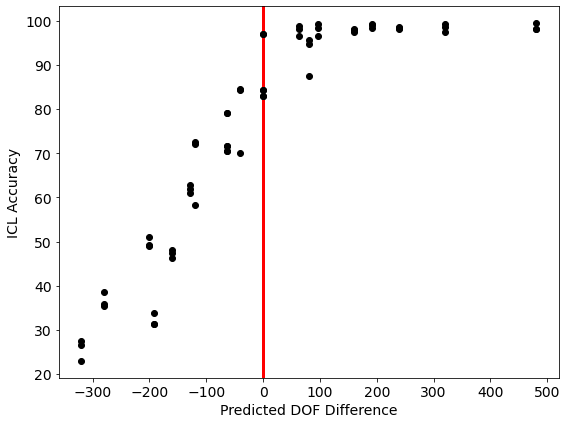

In [10]:
# Import necessary components
import torch
import numpy as np

# Import from refactored modular structure
from data_generation import GaussianMixtureModel, generate_icl_gmm_data
from datasets import ICLGMMDataset, collate_fn
from models import MatrixTreeMarkovICL, NonlinearMarkovICL
from training import train_model
from evaluation import test_icl

from models.nonlinear_markov_icl import *
from models.markov_icl import *
from torch.utils.data import DataLoader
import os
import time
import pickle
import matplotlib.pyplot as plt
import numpy as np

seeds = [1,2,3]
nodes = [4,5]
sparsities = np.arange(0.1, 1.1, 0.1)

needed_dof_list = []
available_dof_list = []
icl_accuracy_list = []
iwl_accuracy_list = []

for seed in seeds:
    for node in nodes:
        for sparsity in sparsities:
            sparsity = round(sparsity, 1)
            path = f"/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/rho_edge_seed_n_nodes{node}_2/{sparsity}_{seed}/"
            results_path = path + "results.pkl"
            with open(results_path, "rb") as file:
                data = pickle.load(file)

            # Extract components
            results = data['results']
            history = data['history']
            params = data['params']
            execution_time = data['execution_time']

            needed_dof = 2 * params['D'] * params['N'] * (params['N']+1)
            #available_dof = params['sparsity_rho_all'] * params['sparsity_rho_edge'] * (params['N']+1) * params['D'] * params['n_nodes'] * (params['n_nodes']-1)
            model = load_model(params, path, print_creation=False)
            available_dof = model.get_non_zero_count_K()

            needed_dof_list.append(needed_dof)
            available_dof_list.append(available_dof)

            icl_acc = [val for val in history['icl_acc'] if val is not None][-1]
            iwl_acc = [val for val in history['iwl_acc'] if val is not None][-1]

            icl_accuracy_list.append(icl_acc)
            iwl_accuracy_list.append(iwl_acc)


dof_diff_list = np.array(available_dof_list) - np.array(needed_dof_list)

plt.figure(figsize=(8, 6))
fs = 14
plt.scatter(dof_diff_list, icl_accuracy_list, label='ICL Accuracy', marker='o', color='black')
#plt.scatter(dof_diff_list, iwl_accuracy_list, label='IWL Accuracy', marker='x')
plt.axvline(x=0, color='red', linestyle='-', linewidth=3, zorder=-10)
plt.xlabel('Predicted DOF Difference',fontsize=fs)
plt.ylabel('ICL Accuracy',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.tight_layout()
plt.show()



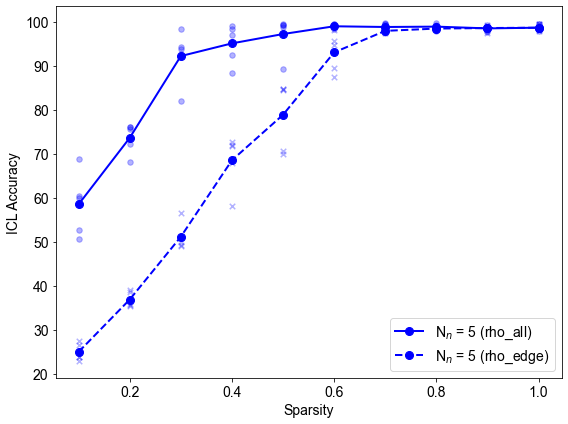

In [ ]:
seeds = [1,2,3,4,5]
nodes = [4,5,6]
nodes = [5]
sparsities = np.arange(0.1, 1.1, 0.1)

# Create a single figure with all data overlaid
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
fs = 14

# Define colors for each node
colors = ['blue', 'red', 'green']

# Define line styles for each dataset
linestyles = {'rho_all': '-', 'rho_edge': '--'}
labels_suffix = {'rho_all': ' (rho_all)', 'rho_edge': ' (rho_edge)'}

for idx, node in enumerate(nodes):
    # Process both rho_all and rho_edge datasets
    for dataset_type in ['rho_all', 'rho_edge']:
        # Dictionary to store accuracies for each sparsity across seeds
        sparsity_accuracies = {round(s, 1): [] for s in sparsities}
        
        for seed in seeds:
            for sparsity in sparsities:
                sparsity = round(sparsity, 1)
                if dataset_type == 'rho_all':
                    path = f"/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/rho_all_seed_n_nodes{node}_2/{sparsity}_{seed}/"
                else:
                    path = f"/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/rho_edge_seed_n_nodes{node}_2/{sparsity}_{seed}/"
                    
                
                results_path = path + "results.pkl"
                with open(results_path, "rb") as file:
                    data = pickle.load(file)

                # Extract components
                results = data['results']
                history = data['history']
                params = data['params']
                execution_time = data['execution_time']

                icl_acc = [val for val in history['icl_acc'] if val is not None][-1]
                
                sparsity_accuracies[sparsity].append(icl_acc)
                
                # Plot original data points
                marker = 'o' if dataset_type == 'rho_all' else 'x'
                ax.scatter(sparsity, icl_acc, color=colors[idx], alpha=0.3, s=30, marker=marker)
        
        # Compute moving average over seeds for each sparsity
        sparsity_list = sorted(sparsity_accuracies.keys())
        avg_accuracy_list = [np.mean(sparsity_accuracies[s]) for s in sparsity_list]
        
        # Plot line for this node and dataset type
        label = f'N$_n$ = {node}{labels_suffix[dataset_type]}'
        ax.plot(sparsity_list, avg_accuracy_list, marker='o', color=colors[idx], 
                label=label, linewidth=2, markersize=8, linestyle=linestyles[dataset_type])

ax.set_xlabel('Sparsity', fontsize=fs)
ax.set_ylabel('ICL Accuracy', fontsize=fs)
ax.tick_params(labelsize=fs)
#ax.grid(True, alpha=0.3)
ax.legend(fontsize=fs)

plt.tight_layout()
plt.show()

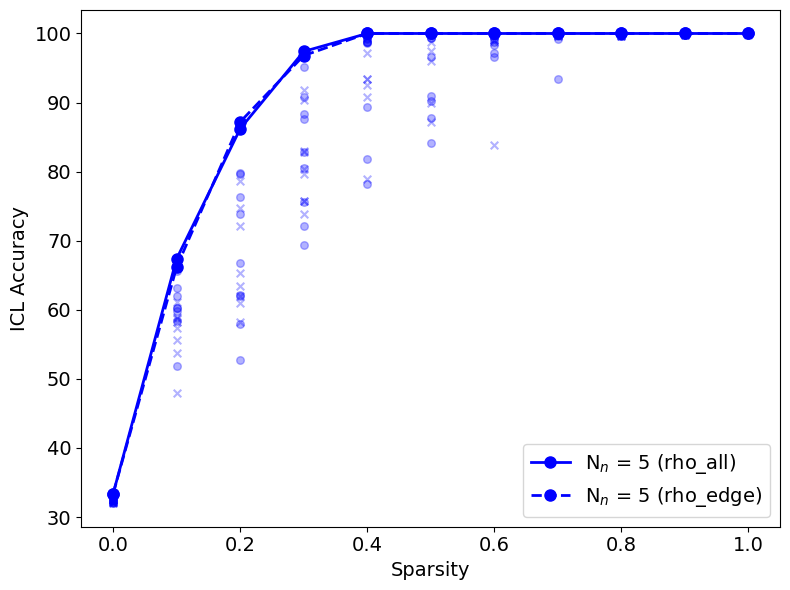

In [3]:
seeds = [1,2,3,4,5,6,7,8,9,10]
nodes = [4,5,6]
nodes = [5]
#sparsities = np.arange(0.2, 1.2, 0.2)
sparsities = np.arange(0.0, 1.1, 0.1)

# Create a single figure with all data overlaid
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
fs = 14

# Define colors for each node
colors = ['blue', 'red', 'green']

# Define line styles for each dataset
linestyles = {'rho_all': '-', 'rho_edge': '--'}
labels_suffix = {'rho_all': ' (rho_all)', 'rho_edge': ' (rho_edge)'}

for idx, node in enumerate(nodes):
    # Process both rho_all and rho_edge datasets
    for dataset_type in ['rho_all', 'rho_edge']:
        # Dictionary to store accuracies for each sparsity across seeds
        sparsity_accuracies = {round(s, 1): [] for s in sparsities}
        
        for seed in seeds:
            for sparsity in sparsities:
                sparsity = round(sparsity, 1)
                if dataset_type == 'rho_all':
                    path = f"/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/rho_all_seed_n_nodes5_nlm0p0_big/{sparsity}_{seed}/"
                else:
                    path = f"/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/rho_all_seed_n_nodes5_nlm0p2_big/{sparsity}_{seed}/"
                    
                
                try:
                    results_path = path + "results.pkl"
                    with open(results_path, "rb") as file:
                        data = pickle.load(file)
                except:
                    continue

                # Extract components
                results = data['results']
                history = data['history']
                params = data['params']
                execution_time = data['execution_time']

                icl_acc = [val for val in history['icl_acc'] if val is not None]
                if len(icl_acc) > 0:
                    #icl_acc = icl_acc[-1]
                    icl_acc = np.max(icl_acc)
                    sparsity_accuracies[sparsity].append(icl_acc)
                    
                    # Plot original data points
                    marker = 'o' if dataset_type == 'rho_all' else 'x'
                    ax.scatter(sparsity, icl_acc, color=colors[idx], alpha=0.3, s=30, marker=marker)
        
        # Compute moving average over seeds for each sparsity
        sparsity_list = sorted(sparsity_accuracies.keys())
        avg_accuracy_list = []
        for s in sparsity_list:
            if len(sparsity_accuracies[s]) > 0:
                avg_accuracy_list.append(np.max(sparsity_accuracies[s]))
            else:
                avg_accuracy_list.append(np.nan)
        
        # Plot line for this node and dataset type (only if we have data)
        if any(~np.isnan(avg_accuracy_list)):
            label = f'N$_n$ = {node}{labels_suffix[dataset_type]}'
            ax.plot(sparsity_list, avg_accuracy_list, marker='o', color=colors[idx], 
                    label=label, linewidth=2, markersize=8, linestyle=linestyles[dataset_type])

ax.set_xlabel('Sparsity', fontsize=fs)
ax.set_ylabel('ICL Accuracy', fontsize=fs)
ax.tick_params(labelsize=fs)
#ax.grid(True, alpha=0.3)
ax.legend(fontsize=fs)

plt.tight_layout()
plt.show()

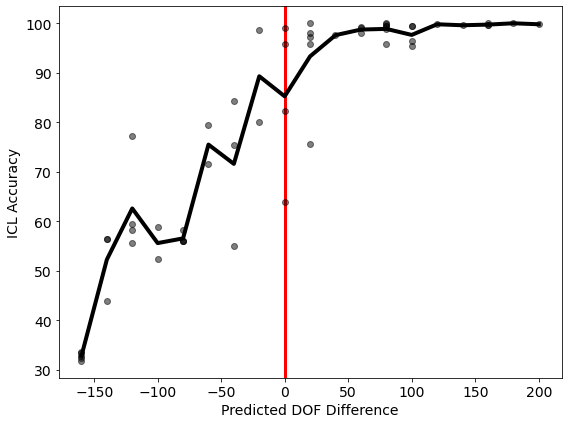

In [27]:
seed_array = [1, 2, 3, 4, 5]
sparsity_array = np.arange(0.0, 0.22, 0.02)
sparsity_array = [round(s,2) for s in sparsity_array]

needed_dof_list = []
available_dof_list = []
icl_accuracy_list = []
iwl_accuracy_list = []

for seed in seed_array:
    for sparsity in sparsity_array:
        path = f"/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/rho_all_seed_n_nodes5_nlm_L_6/{sparsity}_{seed}/"
        results_path = path + "results.pkl"
        with open(results_path, "rb") as file:
            data = pickle.load(file)

        # Extract components
        results = data['results']
        history = data['history']
        params = data['params']
        execution_time = data['execution_time']

        needed_dof = 2 * params['D'] * params['N'] * (params['N']+1)
        model = load_model_nlm(params, path, print_creation=False)
        non_zero_count = non_zero_count = model.get_non_zero_count_L()

        needed_dof_list.append(needed_dof)
        available_dof_list.append(non_zero_count)

        icl_acc = [val for val in history['icl_acc'] if val is not None][-1]
        icl_acc = np.max([val for val in history['icl_acc'] if val is not None])
        iwl_acc = [val for val in history['iwl_acc'] if val is not None][-1]

        icl_accuracy_list.append(icl_acc)
        iwl_accuracy_list.append(iwl_acc)


dof_diff_list = np.array(available_dof_list) - np.array(needed_dof_list)

plt.figure(figsize=(8, 6))
fs = 14
# Sort both lists according to dof_diff_list order
sorted_indices = np.argsort(dof_diff_list)
sorted_dof_diff = np.array(dof_diff_list)[sorted_indices]
sorted_icl_accuracy = np.array(icl_accuracy_list)[sorted_indices]

# Compute running average
# window_size = 9
# running_avg_dof = []
# running_avg_icl = []
# for i in range(len(sorted_dof_diff) - window_size + 1):
#     running_avg_dof.append(np.mean(sorted_dof_diff[i:i+window_size]))
#     running_avg_icl.append(np.mean(sorted_icl_accuracy[i:i+window_size]))

unique_dof_diffs = list(sorted(set(sorted_dof_diff)))
running_avg_icl = []
for i in unique_dof_diffs:
    match_inds = np.where(sorted_dof_diff == i)[0]
    #running_avg_dof.append(np.mean(sorted_dof_diff[match_inds]))
    running_avg_icl.append(np.mean(sorted_icl_accuracy[match_inds]))

plt.scatter(dof_diff_list, icl_accuracy_list, label='ICL Accuracy', marker='o', color='black', alpha=0.5)
plt.plot(unique_dof_diffs, running_avg_icl, label='Running Average', color='black', linewidth=4)
#plt.scatter(dof_diff_list, iwl_accuracy_list, label='IWL Accuracy', marker='x')
plt.axvline(x=0, color='red', linestyle='-', linewidth=3, zorder=-10)
plt.xlabel('Predicted DOF Difference',fontsize=fs)
plt.ylabel('ICL Accuracy',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.tight_layout()
plt.show()

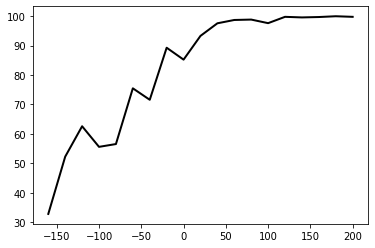

In [25]:
unique_dof_diffs = list(sorted(set(sorted_dof_diff)))
running_avg_icl = []
for i in unique_dof_diffs:
    match_inds = np.where(sorted_dof_diff == i)[0]
    #running_avg_dof.append(np.mean(sorted_dof_diff[match_inds]))
    running_avg_icl.append(np.mean(sorted_icl_accuracy[match_inds]))

#plt.scatter(unique_dof_diffs, icl_accuracy_list, label='ICL Accuracy', marker='o', color='black', alpha=0.5)
plt.plot(unique_dof_diffs, running_avg_icl, label='Running Average', color='black', linewidth=2)
